In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
from nb_001b import *
import sys, PIL, matplotlib.pyplot as plt, itertools, math
import scipy.stats, scipy.special

from enum import Enum, IntEnum
from torch.utils.data import Dataset
from operator import itemgetter, attrgetter
from numpy import random, cos, sin, tan, tanh

import collections
from collections import defaultdict, abc, namedtuple

# CIFAR subset data

## Setup

In [3]:
DATA_PATH = Path('data')
PATH = DATA_PATH/'cifar10_dog_air'
TRAIN_PATH = PATH/'train'

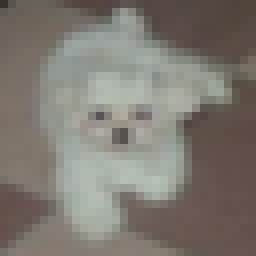

In [4]:
dog_fn = list((TRAIN_PATH/'dog').iterdir())[0]
dog_image = Image.open(dog_fn)
dog_image.resize((256,256))

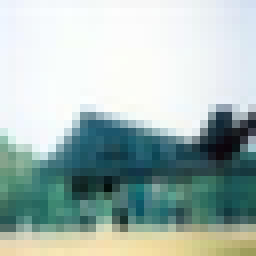

In [5]:
air_fn = list((TRAIN_PATH/'airplane').iterdir())[0]
air_image = Image.open(air_fn)
air_image.resize((256,256))

## Simple Dataset/Dataloader

In [4]:
def find_classes(folder):
    classes = [d for d in folder.iterdir()
               if d.is_dir() and not d.name.startswith('.')]
    assert(len(classes)>0)
    return sorted(classes, key=lambda d: d.name)

def get_image_files(c):
    return [o for o in list(c.iterdir())
            if not o.name.startswith('.') and not o.is_dir()]

def pil2tensor(image):
    arr = np.array(image, dtype=np.float32)/255.
    if len(arr.shape)==2: arr = np.repeat(arr[...,None],3,2)
    return torch.from_numpy(arr).permute(2,0,1).contiguous()

In [5]:
class FilesDataset(Dataset):
    def __init__(self, folder, classes):
        self.fns, self.y = [], []
        self.classes = classes
        for i, cls in enumerate(classes):
            fnames = get_image_files(folder/cls)
            self.fns += fnames
            self.y += [i] * len(fnames)
        
    def __len__(self): return len(self.fns)

    def __getitem__(self,i):
        x = PIL.Image.open(self.fns[i]).convert('RGB')
        return pil2tensor(x),self.y[i]

In [6]:
# NB: validation or training may not have all classes
classes = [cls.name for cls in find_classes(PATH/'train')]

train_ds = FilesDataset(PATH/'train', classes)
valid_ds = FilesDataset(PATH/'test', classes)

In [7]:
len(train_ds), len(valid_ds)

(10000, 2000)

In [8]:
def image2np(image): return image.cpu().permute(1,2,0).numpy()

airplane


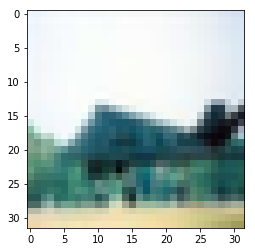

In [11]:
x,y = train_ds[0]
plt.imshow(image2np(x))
print(train_ds.classes[y])

In [9]:
import torch
default_device = torch.device('cuda', 0)

In [10]:
bs=64

In [11]:
data = DataBunch(train_ds, valid_ds, bs=bs)
len(data.train_dl), len(data.valid_dl)

(157, 16)

In [12]:
def show_image(img, ax=None, figsize=(3,3)):
    if ax is None: fig,ax = plt.subplots(figsize=figsize)
    ax.imshow(image2np(img))
    ax.axis('off')

def show_image_batch(dl, classes, rows=None):
    if rows is None: rows = int(math.sqrt(len(x)))
    x,y = next(iter(dl))[:rows*rows]
    show_images(x,y,rows, classes)

def show_images(x,y,rows, classes):
    fig, axs = plt.subplots(rows,rows,figsize=(12,15))
    for i, ax in enumerate(axs.flatten()):
        show_image(x[i], ax)
        ax.set_title(classes[y[i]])
    plt.tight_layout()

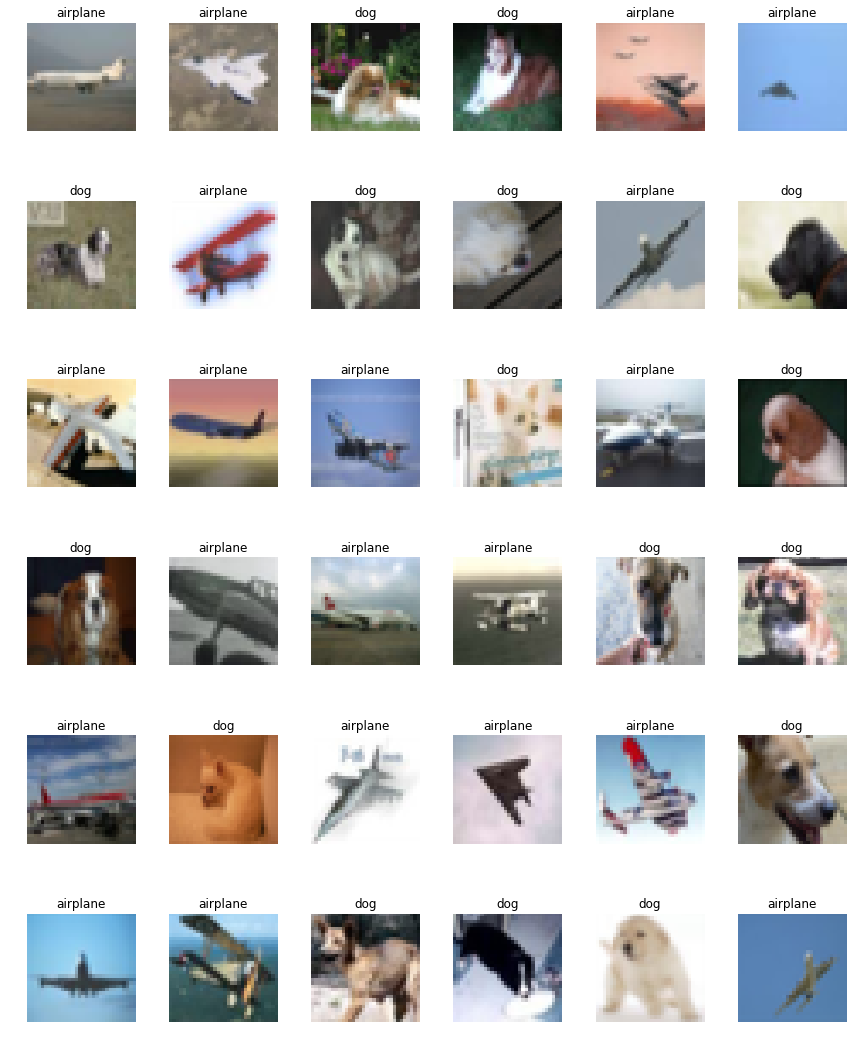

In [16]:
show_image_batch(data.train_dl, classes, 6)

## Simplify transforms

In [17]:
x,_ = next(iter(data.train_dl))

In [18]:
x.shape

torch.Size([64, 3, 32, 32])

In [13]:
def get_batch_stats(dl):
    x,_ = next(iter(dl))
    # hack for multi-axis reduction until pytorch has it natively
    x = x.transpose(0,1).contiguous().view(x.size(1),-1)
    return x.mean(1), x.std(1)

In [20]:
data_mean,data_std = get_batch_stats(data.train_dl)
data_mean,data_std

(tensor([0.5177, 0.5309, 0.5087], device='cuda:0'),
 tensor([0.2666, 0.2570, 0.2813], device='cuda:0'))

In [14]:
noop = lambda x: x

def xy_transform(x_tfm=None, y_tfm=None):
    if x_tfm is None: x_tfm = noop
    if y_tfm is None: y_tfm = noop
    return lambda b: (x_tfm(b[0]), y_tfm(b[1]))

def xy_transforms(x_tfms=None, y_tfms=None):
    x_tfms = listify(x_tfms)
    if y_tfms is None: y_tfms=noop
    y_tfms = listify(y_tfms, x_tfms)
    return list(map(xy_transform, x_tfms, y_tfms))

In [15]:
def normalize(mean,std,x): return (x-mean.reshape(3,1,1))/std.reshape(3,1,1)

In [23]:
cifar_transforms = [
    partial(normalize, data_mean, data_std)
]

cifar_xy_transforms = xy_transforms(cifar_transforms)

In [24]:
data2 = DataBunch(train_ds, valid_ds, bs=bs, train_tfms=cifar_xy_transforms, valid_tfms=cifar_xy_transforms)
len(data2.train_dl), len(data2.valid_dl)

(157, 16)

In [25]:
x,y = next(iter(data2.train_dl))

In [26]:
def denorm(x): return x * data_std.reshape(3,1,1) + data_mean.reshape(3,1,1)

In [27]:
x = denorm(x)

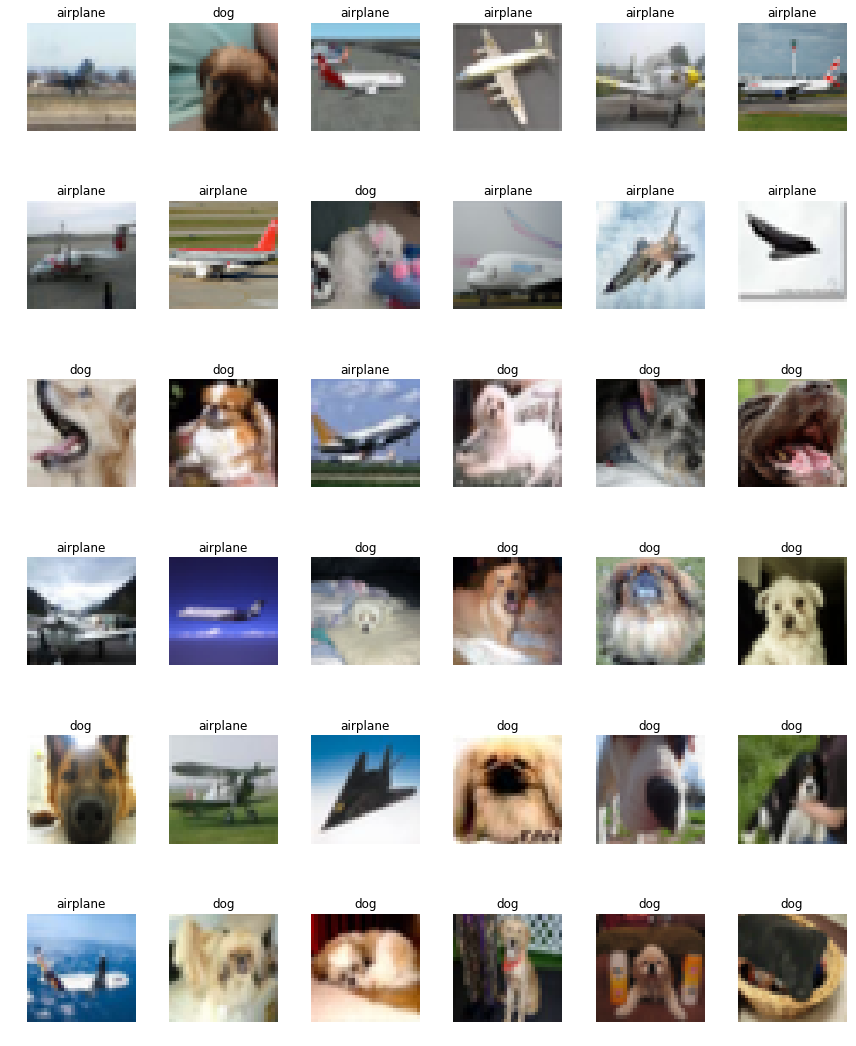

In [28]:
show_images(x,y,6,classes)

In [29]:
learn = Learner(data2, simple_cnn([3,16,16,2], [3,3,3], [2,2,2]))

In [30]:
learn.fit(2, 0.1)

0 0.3913720116615295


1 0.31789488935470583



# Data augmentation

## Lighting

In [16]:
TfmType = IntEnum('TfmType', 'Pixel Coord Affine')

In [17]:
def log_uniform(low, high): return np.exp(random.uniform(np.log(low), np.log(high)))

In [18]:
scipy.stats.gmean([log_uniform(0.5,2.0) for _ in range(1000)])

1.0033424614381083

In [19]:
def logit(x): return (x/(1-x)).log()
def logit_(x): return (x.div_(1-x)).log_()

In [20]:
def brightness(x, change: random.uniform) -> TfmType.Pixel:
    return x.add_(scipy.special.logit(change))

def contrast(x, scale: log_uniform) -> TfmType.Pixel:
    return x.mul_(scale)

In [22]:
def apply_pixel_tfm(func): return lambda x: func(logit_(x)).sigmoid()
def apply_contrast(scale): return apply_pixel_tfm(partial(contrast, scale=scale))

In [23]:
x = lambda: train_ds[1][0]

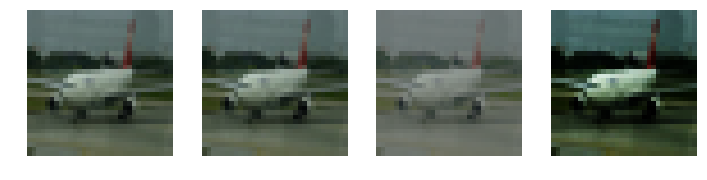

In [51]:
_,axes = plt.subplots(1,4, figsize=(12,3))

show_image(x(), axes[0])
show_image(apply_contrast(1.0)(x()), axes[1])
show_image(apply_contrast(0.5)(x()), axes[2])
show_image(apply_contrast(2.0)(x()), axes[3])

In [24]:
def apply_brightness(change):
    return apply_pixel_tfm(partial(brightness, change=change))

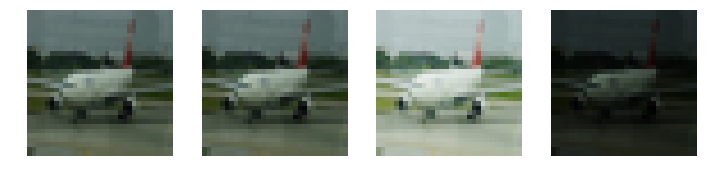

In [53]:
_,axes = plt.subplots(1,4, figsize=(12,3))

show_image(x(), axes[0])
show_image(apply_brightness(0.5)(x()), axes[1])
show_image(apply_brightness(0.8)(x()), axes[2])
show_image(apply_brightness(0.2)(x()), axes[3])

In [25]:
def apply_brightness_contrast(scale_contrast, change_brightness):
    return apply_pixel_tfm(compose([
        partial(contrast, scale=scale_contrast),
        partial(brightness, change=change_brightness)
    ]))

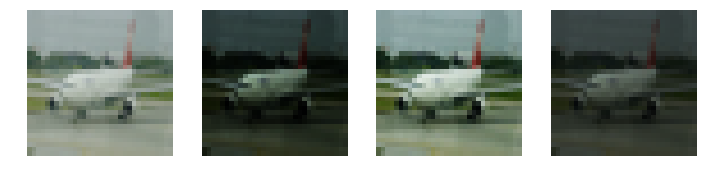

In [55]:
_,axes = plt.subplots(1,4, figsize=(12,3))

show_image(apply_brightness_contrast(0.75, 0.7)(x()), axes[0])
show_image(apply_brightness_contrast(1.3,  0.3)(x()), axes[1])
show_image(apply_brightness_contrast(1.3,  0.7)(x()), axes[2])
show_image(apply_brightness_contrast(0.75, 0.3)(x()), axes[3])

## Random lighting

In [26]:
def resolve_args(func, **kwargs):
    return {k:v(*kwargs[k]) for k,v in func.__annotations__.items() if k != 'return'}

In [57]:
resolve_args(brightness, change=(0.25,0.75))

{'change': 0.6440085579863002}

In [27]:
this_module = sys.modules[__name__]

In [28]:
def copy_anno(func, new_func):
    def _inner(*args, **kwargs):
        res = new_func(*args, **kwargs)
        res.__annotations__ = func.__annotations__
        return res
    return _inner

In [29]:
def make_tfm_funcs(func):
    rfunc = lambda **kwargs: partial(func, **resolve_args(func, **kwargs))
    tfunc = copy_anno(func, lambda **kwargs: lambda x: rfunc(**kwargs)(x))
    setattr(this_module, f'{func.__name__}_rand', rfunc)
    setattr(this_module, f'{func.__name__}_tfm', tfunc)

In [63]:
make_tfm_funcs(brightness)
make_tfm_funcs(contrast)

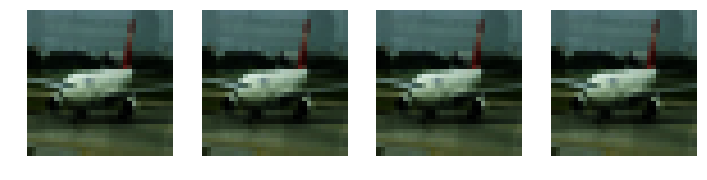

In [64]:
tfm = apply_pixel_tfm(contrast_rand(scale=(0.5,2.0)))

# all the same
_,axes = plt.subplots(1,4, figsize=(12,3))
for ax in axes: show_image(tfm(x()), ax)

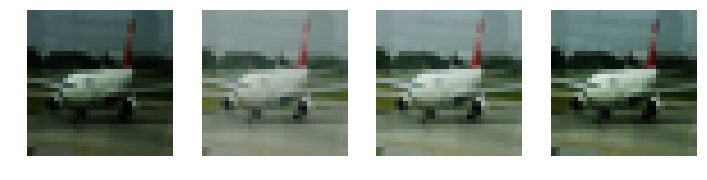

In [65]:
tfms = [contrast_tfm(scale=(0.5,2.0)),
        brightness_tfm(change=(0.25,0.75))]
tfm = apply_pixel_tfm(compose(tfms))

# all different
_,axes = plt.subplots(1,4, figsize=(12,3))
for ax in axes: show_image(tfm(x()), ax)

## Decorator

In [30]:
def reg_transform(func):
    make_tfm_funcs(func)
    return func

In [31]:
@reg_transform
def brightness(x, change: random.uniform) -> TfmType.Pixel:
    return x.add_(scipy.special.logit(change))

@reg_transform
def contrast(x, scale: log_uniform) -> TfmType.Pixel:
    return x.mul_(scale)

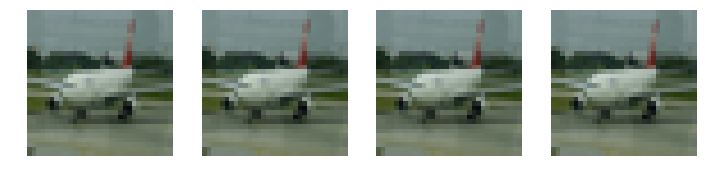

In [71]:
_,axes = plt.subplots(1,4, figsize=(12,3))

tfm = apply_pixel_tfm(brightness_rand(change=(0.2,0.8)))
for ax in axes: show_image(tfm(x()), ax)

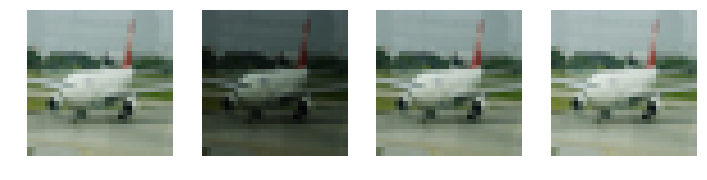

In [72]:
_,axes = plt.subplots(1,4, figsize=(12,3))

tfm = apply_pixel_tfm(brightness_tfm(change=(0.2,0.8)))
for ax in axes: show_image(tfm(x()), ax)

# Affine

## Deterministic affine

In [32]:
def grid_sample(x, coords, padding='reflect'):
    if padding=='reflect': # Reflect padding isn't implemented in grid_sample yet
        coords[coords < -1] = coords[coords < -1].mul_(-1).add_(-2)
        coords[coords > 1] = coords[coords > 1].mul_(-1).add_(2)
        padding='zeros'
    return F.grid_sample(x[None], coords, padding_mode=padding)[0]

def affine_grid(x, matrix): return F.affine_grid(matrix[None,:2], x[None].size())

In [33]:
def rotate(degrees: random.uniform) -> TfmType.Affine:
    angle = degrees * math.pi / 180
    return [[cos(angle), -sin(angle), 0.],
            [sin(angle),  cos(angle), 0.],
            [0.        ,  0.        , 1.]]

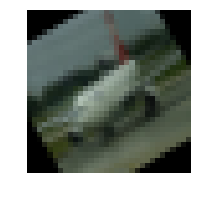

In [75]:
img = x()
m = rotate(30)
m = img.new_tensor(m)
c = affine_grid(img, m)
img2 = grid_sample(img, c, padding='zeros')
show_image(img2)

In [49]:
def do_affine(img, m=None, funcs=None):
    if m is None: m=eye_new(x, 3)
    c = affine_grid(img,  img.new_tensor(m))
    c = compose(funcs)(c)
    return grid_sample(img, c, padding='zeros')

In [35]:
def zoom(scale: random.uniform) -> TfmType.Affine:
    return [[scale, 0,     0.],
            [0,     scale, 0.],
            [0,     0   ,  1.]]

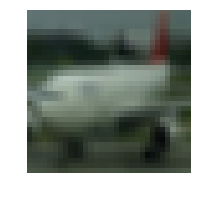

In [78]:
show_image(do_affine(x(), zoom(0.6)))

In [36]:
def eye_new(x, n): return torch.eye(n, out=x.new_empty((n,n)))

def affines_mat(x, matrices):
    matrices = list(map(x.new_tensor, matrices))
    return reduce(torch.matmul, matrices, eye_new(x, 3))

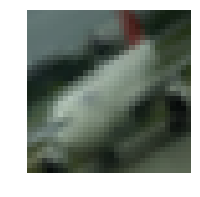

In [80]:
img = x()
c = affines_mat(img, [zoom(0.6), rotate(30)])
show_image(do_affine(img, c))

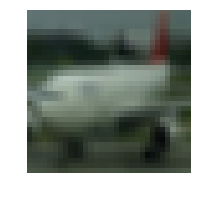

In [81]:
img = x()
img2 = do_affine(img,  rotate(30))
img2 = do_affine(img2, zoom(0.6))
show_image(img2)

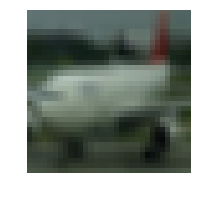

In [82]:
img = x()
c = affines_mat(img, [zoom(0.6)])
show_image(do_affine(img, c))

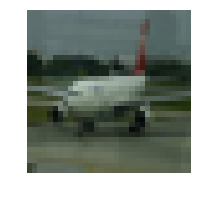

In [83]:
img = x()
c = affines_mat(img, [])
show_image(do_affine(img, c))

## Random affine

In [37]:
def affine_rand(func, **kwargs): return func(**resolve_args(func, **kwargs))

In [38]:
def make_affine_funcs(func):
    rfunc = partial(affine_rand, func)
    tfunc = copy_anno(func, lambda **kwargs: lambda: rfunc(**kwargs))
    setattr(this_module, f'{func.__name__}_rand', rfunc)
    setattr(this_module, f'{func.__name__}_tfm', tfunc)

In [39]:
def apply_affine_tfms(x, funcs):
    matrices = [f() for f in listify(funcs)]
    return do_affine(x, affines_mat(x, matrices))

In [40]:
make_affine_funcs(rotate)
make_affine_funcs(zoom)

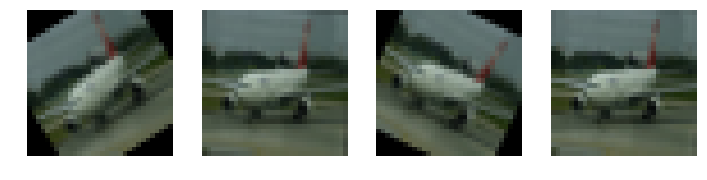

In [88]:
tfm = rotate_tfm(degrees=(-45,45.))

_,axes = plt.subplots(1,4, figsize=(12,3))
for ax in axes: show_image(apply_affine_tfms(x(), tfm), ax)

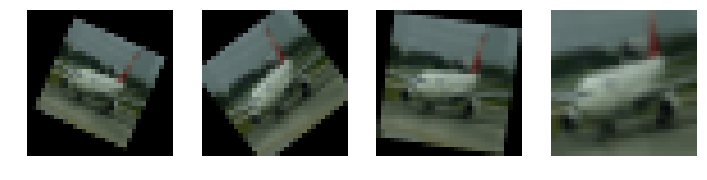

In [89]:
tfms = [rotate_tfm(degrees=(-45,45.)),
        zoom_tfm(scale=(0.75,1.5))]

_,axes = plt.subplots(1,4, figsize=(12,3))
for ax in axes: show_image(apply_affine_tfms(x(), tfms), ax)

## Decorator

In [41]:
def reg_affine(func):
    make_affine_funcs(func)
    return func

In [42]:
@reg_affine
def rotate(degrees: random.uniform) -> TfmType.Affine:
    angle = degrees * math.pi / 180
    return [[cos(angle), -sin(angle), 0.],
            [sin(angle),  cos(angle), 0.],
            [0.        ,  0.        , 1.]]

@reg_affine
def zoom(scale: random.uniform) -> TfmType.Affine:
    return [[scale, 0,     0.],
            [0,     scale, 0.],
            [0,     0   ,  1.]]

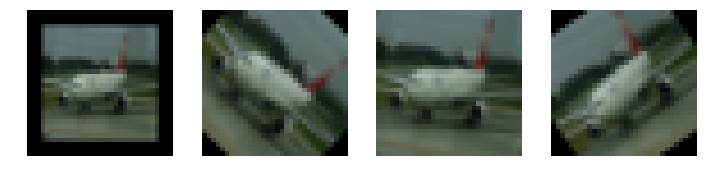

In [92]:
tfms = [rotate_tfm(degrees=(-45,45.)),
        zoom_tfm(scale=(0.75,1.5))]

_,axes = plt.subplots(1,4, figsize=(12,3))
for ax in axes: show_image(apply_affine_tfms(x(), tfms), ax)

## Jitter

In [43]:
@reg_transform
def jitter(x, magnitude: random.uniform) -> TfmType.Coord:
    return x.add_((torch.rand_like(x)-0.5)*magnitude*2)

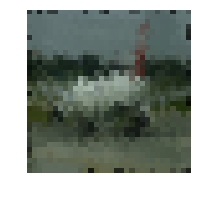

In [94]:
show_image(do_affine(x(), funcs=partial(jitter, magnitude=0.05)))

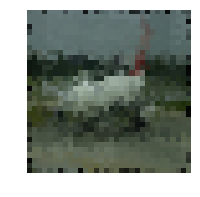

In [95]:
show_image(do_affine(x(), funcs=jitter_rand(magnitude=(0,0.1))))

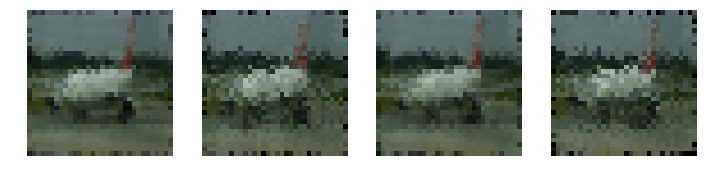

In [96]:
tfm = jitter_tfm(magnitude=(0,0.1))

_,axes = plt.subplots(1,4, figsize=(12,3))
for ax in axes: show_image(do_affine(x(), funcs=tfm), ax)

# Transform pipeline

In [57]:
def dict_groupby(iterable, key=None):
    return {k:list(v) for k,v in itertools.groupby(sorted(iterable, key=key), key=key)}

In [58]:
dict_groupby(tfms, lambda o: o.__annotations__['return'])

{<TfmType.Pixel: 1>: [<function __main__.make_tfm_funcs.<locals>.<lambda>.<locals>.<lambda>(x) -> <TfmType.Pixel: 1>>,
  <function __main__.make_tfm_funcs.<locals>.<lambda>.<locals>.<lambda>(x) -> <TfmType.Pixel: 1>>],
 <TfmType.Coord: 2>: [<function __main__.make_tfm_funcs.<locals>.<lambda>.<locals>.<lambda>(x) -> <TfmType.Coord: 2>>],
 <TfmType.Affine: 3>: [<function __main__.make_affine_funcs.<locals>.<lambda>.<locals>.<lambda>() -> <TfmType.Affine: 3>>,
  <function __main__.make_affine_funcs.<locals>.<lambda>.<locals>.<lambda>() -> <TfmType.Affine: 3>>]}

In [59]:
def apply_pipeline(x, tfms):
    tfms = listify(tfms)
    if len(tfms)==0: return x
    grouped_tfms = dict_groupby(tfms, lambda o: o.__annotations__['return'])
    pixel_tfms,coord_tfms,affine_tfms = map(grouped_tfms.get, TfmType)
    x = apply_pixel_tfm(compose(pixel_tfms))(x)
    matrices = [f() for f in listify(affine_tfms)]
    x = do_affine(x, affines_mat(x, matrices), funcs=coord_tfms)
    return x

In [56]:
tfms = [jitter_tfm(magnitude=(0,0.05)),
        rotate_tfm(degrees=(-45,45.)),
        zoom_tfm(scale=(0.75,1.5)),
        contrast_tfm(scale=(0.5,2.0)),
        brightness_tfm(change=(0.25,0.75))]

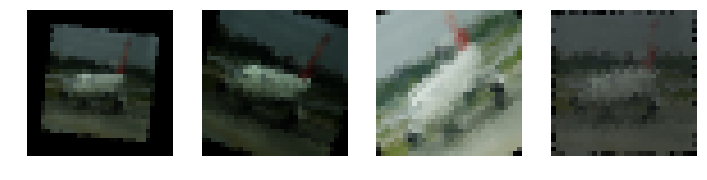

In [60]:
_,axes = plt.subplots(1,4, figsize=(12,3))
for ax in axes: show_image(apply_pipeline(x(), tfms), ax)

## Fin